# Лабораторная работа №4
## Исследование кривых обучения и регуляризации

Целевая переменная: `MEDV` (средняя стоимость жилья)

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import seaborn as sns

# Названия столбцов из описания датасета
column_names = [
    "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE",
    "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT", "MEDV"
]

# Загрузка с разделителем по нескольким пробела
df = pd.read_csv("housing.csv", sep=r'\s+', header=None, names=column_names)

df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


## 1. Кривые обучения для двух моделей

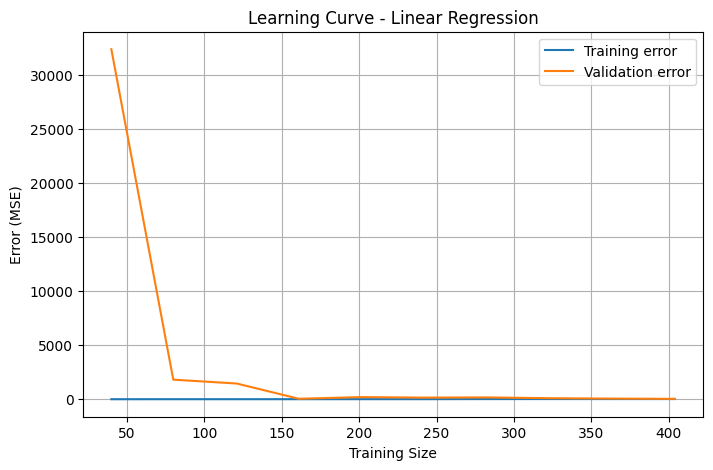

(array([ 3.0999518 ,  5.08830007,  5.50682983,  7.06423803,  9.22058656,
         9.0228297 , 17.92535839, 19.65983312, 18.77103937, 20.62989355]),
 array([32367.61231747,  1812.29337067,  1454.51422959,    47.37726743,
          200.144433  ,   151.46998915,   170.22372167,    98.15556327,
           62.06116938,    36.75280964]))

In [14]:
X = df.drop("MEDV", axis=1)
y = df["MEDV"]

# Функция кривой обучения
def plot_learning_curve(estimator, title, X, y, cv=5, scoring='neg_mean_squared_error'):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), random_state=42)

    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_scores_mean, label="Training error")
    plt.plot(train_sizes, test_scores_mean, label="Validation error")
    plt.title(title)
    plt.xlabel("Training Size")
    plt.ylabel("Error (MSE)")
    plt.grid(True)
    plt.legend()
    plt.show()
    return train_scores_mean, test_scores_mean

plot_learning_curve(LinearRegression(), "Learning Curve - Linear Regression", X, y)

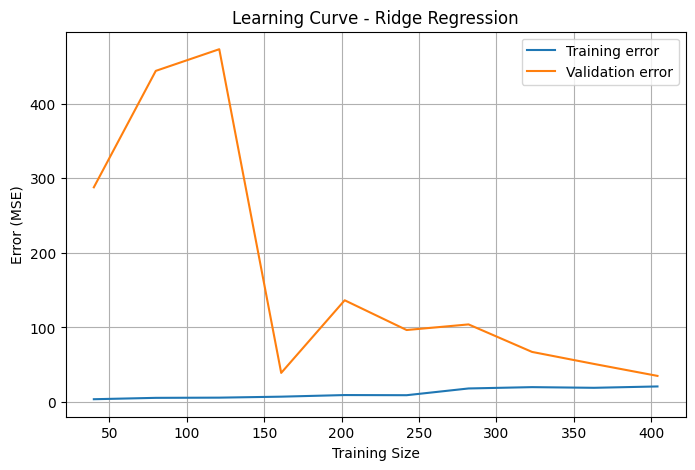

(array([ 3.7397561 ,  5.58007596,  5.8532672 ,  7.16637073,  9.32276327,
         9.12434501, 18.16852294, 19.93739005, 19.04094661, 20.86158007]),
 array([287.80952972, 443.89000892, 472.91846245,  39.01593313,
        136.38673712,  96.50925508, 104.02439418,  67.14993415,
         51.0434509 ,  35.00832963]))

In [15]:
plot_learning_curve(Ridge(alpha=1.0), "Learning Curve - Ridge Regression", X, y)

## 2. Обучение моделей: Linear, Ridge, Lasso

In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1)
}

results = {}
coefficients = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred)
    }
    coefficients[name] = model.coef_

pd.DataFrame(results).T

,MAE,MSE,R2
Linear,3.162710,21.517444,0.711226
Ridge,3.160941,21.548500,0.710809
Lasso,3.209117,22.797913,0.694042


## Таблица коэффициентов моделей

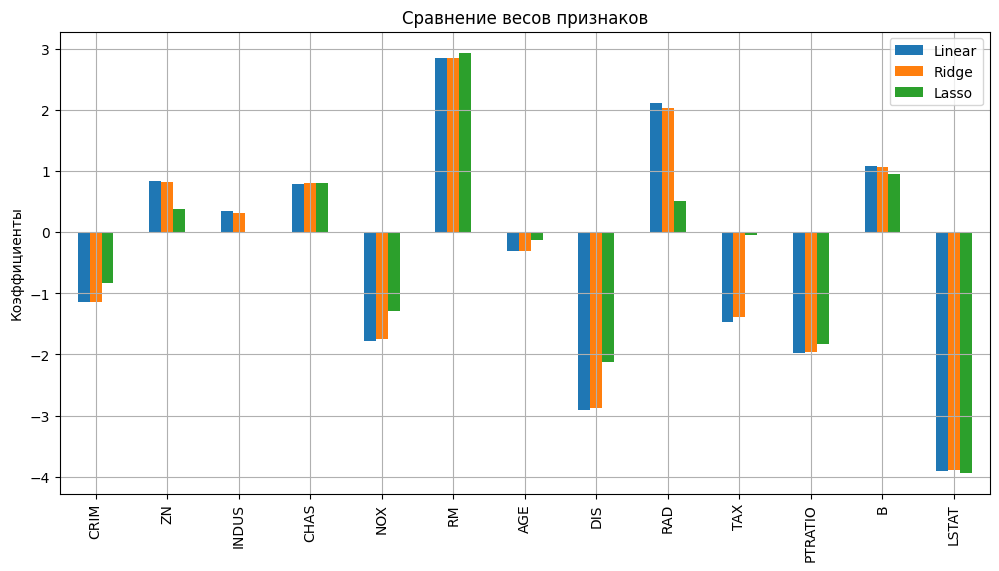

,Linear,Ridge,Lasso
CRIM,-1.146914,-1.133655,-0.824781
ZN,0.834326,0.812628,0.384616
INDUS,0.339407,0.310566,-0.000000
CHAS,0.791636,0.797254,0.806004
NOX,-1.784727,-1.749523,-1.289769
RM,2.847839,2.854456,2.937899
AGE,-0.304293,-0.307262,-0.124835
DIS,-2.915625,-2.875986,-2.125033
RAD,2.111400,2.027825,0.505608
TAX,-1.465200,-1.391496,-0.039543


In [17]:
coef_df = pd.DataFrame(coefficients, index=X.columns)
coef_df.plot(kind='bar', figsize=(12, 6))
plt.title("Сравнение весов признаков")
plt.ylabel("Коэффициенты")
plt.grid(True)
plt.show()
coef_df

## 3. ElasticNet

ElasticNet R2: 0.6983074639688323
ElasticNet MSE: 22.48004476940257


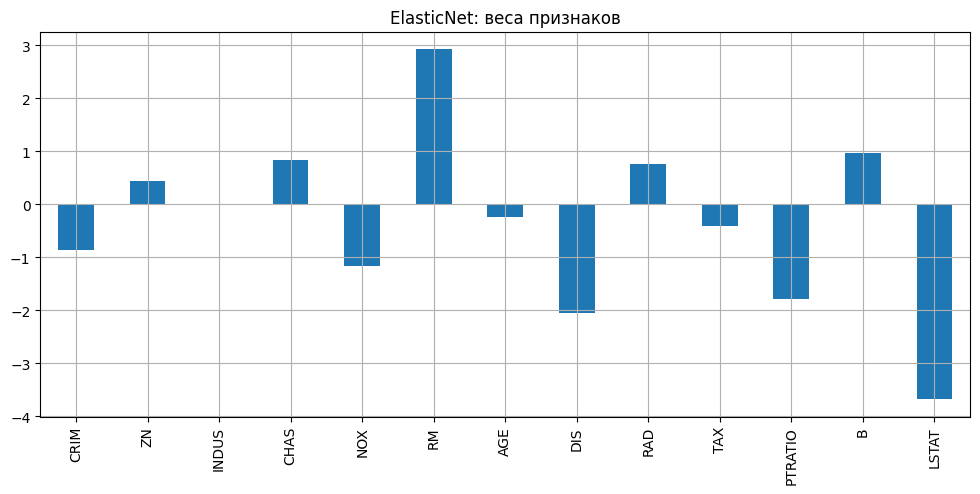

In [18]:
elastic = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic.fit(X_train, y_train)
elastic_pred = elastic.predict(X_test)

print("ElasticNet R2:", r2_score(y_test, elastic_pred))
print("ElasticNet MSE:", mean_squared_error(y_test, elastic_pred))

pd.Series(elastic.coef_, index=X.columns).plot(kind='bar', figsize=(12, 5))
plt.title("ElasticNet: веса признаков")
plt.grid()
plt.show()